#       Understanding the Relationship between Patient Survey Ratings and                    Overall Hospital Ratings

####Kasi Bharath Vegesana

The purpose of this study is to observe the relationship of a hospitals overall rating to patient survey metrics that have been collected by hospitals and other medical centers.
In this study we will use data from the Hospital Compare website as aggregated by the Government Medicare website https://data.medicare.gov/data/hospital-compare

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
%matplotlib inline

The Medicare website provides over 50 csv files for analysis. These files contain data at the individual hospital level, state level and national level. The data covers various metrics that could be used to evaluate a hospitals performance. These range from quantitative data like medicare payments and readmission rates to more qualitative data like patient satisfaction, as obtained from a survey. 

The data of interest to us is the Hospital Consumer Assessment of Healthcare Providers and Systems (HCAHPS) Patient Survey. is a survey instrument and data collection methodology for measuring patients’ perceptions of their hospital experience. The survey is administered to a random sample of adult inpatients after discharge. 

The HCAHPS survey contains patient perspectives on care and patient rating items that encompass key topics: communication with hospital staff, responsiveness of hospital staff, pain management, communication about medicines, discharge information, cleanliness of hospital environment, quietness of hospital environment, and transition of care. In addition to this data, we will also take a brief look at hospital readmision rates to observe avenues for future analysis.

In [2]:
hcahsp = pd.read_csv('HCAHPS - Hospital.csv')
rdeathsp = pd.read_csv('Readmissions and Deaths - Hospital.csv')

We have data availability for all 50 states. However, for demonstrative puposes I have chosen to concentrate only on Virginia based hospitals.

In [3]:
uvahsp = hcahsp[(hcahsp['State'] == 'VA')]
uvadeaths = rdeathsp[(rdeathsp['State'] == 'VA')]

Before we talk a look at the patient surveys, let us see if the overall rating of the hospitals is in any way corelated to the overall 30-day readmision score for patients. The following cell merges the hopital rating data and 30-day readmisiion score data and plots a graph for the hospital rating vs readmission score. 

The corelation between these two variables is also calculated using the pearson corelation factor and the associated p-value. We can see that there is a very weak corealtion between the two variables at a 95% confidence interval. 

C:\Users\kasi Bharat\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


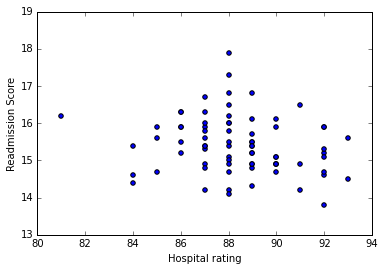

(-0.19483996204619736, 0.093911016148445728)

In [4]:
tempnorf1 = uvahsp[(uvahsp['HCAHPS Measure ID']=='H_HSP_RATING_LINEAR_SCORE')]
tempnorf2 = uvadeaths[(uvadeaths['Measure ID']=='READM_30_HOSP_WIDE')]
jointable=pd.merge(tempnorf1[tempnorf1['HCAHPS Linear Mean Value']!='Not Available'],tempnorf2,
                   on='Hospital Name',how='inner')
plt.scatter([jointable['HCAHPS Linear Mean Value'].values],[jointable['Score'].values])
plt.xlabel('Hospital rating')
plt.ylabel('Readmission Score')
plt.show()
pearsonr(jointable['HCAHPS Linear Mean Value'].values.astype(float),jointable['Score'].values.astype(float))


The HCAHPS data file contains linear mean scores for various survey questions filled out by the patient. These scores represent a patients satisfaction with different metrics like cleanliness, communication with the doctors and nurses, staff responsiveness, help with pain management, communication about medicines, discharge information, care transition and overall perception of the hopital.

The data lacks values for some of these metrics for certain hospitals. this could be due to unavailability of survey data or because the sample size was too small. This hospitals that lack this data are eliminated from our study. We create a dataframe for the remaining hopitals by using the hospital name as an index.

In [5]:
tempnorf1=uvahsp[(uvahsp['HCAHPS Measure ID'].str.contains('_LINEAR_SCORE'))]
tempnorf1=tempnorf1[tempnorf1['HCAHPS Linear Mean Value']!='Not Available']
regcols=['Hospital Name']
regcols=np.append(regcols,np.unique(tempnorf1['HCAHPS Measure ID']))
regdata =pd.DataFrame(columns=regcols)
temp2=np.array([])
for key, groups in tempnorf1.groupby('Hospital Name'):
    temp=np.array([])
    for name in regcols[1:]:
        temp=np.append(temp,groups[groups['HCAHPS Measure ID']==name]['HCAHPS Linear Mean Value'])
        
    temp=np.append([key],temp)
    regdata=pd.concat([pd.DataFrame([temp],columns=regcols),regdata])
    
regdata.index=regdata['Hospital Name']
regdata.drop('Hospital Name',axis=1,inplace=True)
regdata.columns

Index([u'H_CLEAN_LINEAR_SCORE', u'H_COMP_1_LINEAR_SCORE',
       u'H_COMP_2_LINEAR_SCORE', u'H_COMP_3_LINEAR_SCORE',
       u'H_COMP_4_LINEAR_SCORE', u'H_COMP_5_LINEAR_SCORE',
       u'H_COMP_6_LINEAR_SCORE', u'H_COMP_7_LINEAR_SCORE',
       u'H_HSP_RATING_LINEAR_SCORE', u'H_QUIET_LINEAR_SCORE',
       u'H_RECMND_LINEAR_SCORE'],
      dtype='object')

The overall hospital rating is a value in the range [0-100]. For the hopitals surveyed in Virginia, the average value was around 85, with very little variace as seen in the bar graph plotted below.

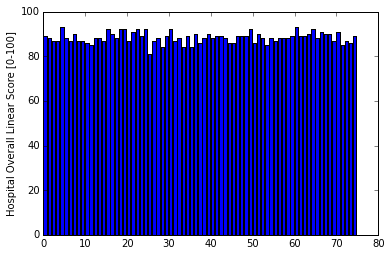

In [6]:
plt.bar(np.arange(len(regdata['H_HSP_RATING_LINEAR_SCORE'])),regdata['H_HSP_RATING_LINEAR_SCORE'].astype(float))
plt.ylabel('Hospital Overall Linear Score [0-100]')
plt.show()


Next, the corelations between the various variables was evaluated to observe the dependence of the overall rating to the individual rating measures. We can see from the table that the overall rating is strongly corelated to multiple variables. Additionally several of the input variables are strongly corelated to each other. This could potentially result in redundant features while building predictive models, and could increase the time complexity of such a predictive model.

In [7]:
regdata=regdata.astype(float)
regdata.corr()

,H_CLEAN_LINEAR_SCORE,H_COMP_1_LINEAR_SCORE,H_COMP_2_LINEAR_SCORE,H_COMP_3_LINEAR_SCORE,H_COMP_4_LINEAR_SCORE,H_COMP_5_LINEAR_SCORE,H_COMP_6_LINEAR_SCORE,H_COMP_7_LINEAR_SCORE,H_HSP_RATING_LINEAR_SCORE,H_QUIET_LINEAR_SCORE,H_RECMND_LINEAR_SCORE
H_CLEAN_LINEAR_SCORE,1.000000,0.533145,0.197543,0.533607,0.311328,0.353729,-0.085055,0.283188,0.249431,0.175466,0.218564
H_COMP_1_LINEAR_SCORE,0.533145,1.000000,0.589147,0.827624,0.728895,0.711936,0.400096,0.690506,0.657659,0.285211,0.571382
H_COMP_2_LINEAR_SCORE,0.197543,0.589147,1.000000,0.584082,0.549532,0.639773,0.458799,0.393650,0.550537,0.455901,0.342776
H_COMP_3_LINEAR_SCORE,0.533607,0.827624,0.584082,1.000000,0.637793,0.709921,0.348677,0.558217,0.541781,0.327027,0.348224
H_COMP_4_LINEAR_SCORE,0.311328,0.728895,0.549532,0.637793,1.000000,0.597920,0.364832,0.629483,0.661189,0.347301,0.545067
H_COMP_5_LINEAR_SCORE,0.353729,0.711936,0.639773,0.709921,0.597920,1.000000,0.440415,0.479781,0.537267,0.356477,0.341828
H_COMP_6_LINEAR_SCORE,-0.085055,0.400096,0.458799,0.348677,0.364832,0.440415,1.000000,0.500931,0.553047,0.193248,0.458478
H_COMP_7_LINEAR_SCORE,0.283188,0.690506,0.393650,0.558217,0.629483,0.479781,0.500931,1.000000,0.726594,0.133590,0.804529
H_HSP_RATING_LINEAR_SCORE,0.249431,0.657659,0.550537,0.541781,0.661189,0.537267,0.553047,0.726594,1.000000,0.399329,0.860315
H_QUIET_LINEAR_SCORE,0.175466,0.285211,0.455901,0.327027,0.347301,0.356477,0.193248,0.133590,0.399329,1.000000,0.129237


## Predicting Overall Rating using various Regression methods

In this section we will take a look at the available regression methods to compare their predictive performance when predicting the overall hospital rating from a selected list of input features.

The first method used is the Ridge regression method for different degrees of regression. There are 8 input features, with the overall hospital rating being the output variable of interest. The score/prediction accuracy for different degrees of regression is also displayed below.

The first and second order regression produced underwhelming fits for the data. This was surprising since most of the imput features showed a strong corelation to the output variable. 

I then considered higher orders of polynomial regression, and these seemed to produce a near accurate fit to the data. THe fifth degree regression produced an almost 100% accuracy. This level of accuracy can be suspect as it might have been a case of overfitting the data, since the training and testing sets were the same.

In [16]:
for degree in [1,2,3,4,5]:
    model =make_pipeline(PolynomialFeatures(degree),Ridge())
    model.fit(regdata.iloc[:,0:7],regdata.iloc[:,8])
    print 'The score for degree %d'%degree, 'is',model.score(regdata.iloc[:,0:7],regdata.iloc[:,8])

The score for degree 1 is 0.595104476528
The score for degree 2 is 0.695589447144
The score for degree 3 is 0.997200476299
The score for degree 4 is 0.99999999825
The score for degree 5 is 0.999999999795


The next regression methods used are from the random forest families. These methods create multiple trees from the input feature set and try to predict the output by creating splits in the input features for best performance. The RandomForest Regressor, and ExtraTreesRegressor had an underwhelming performance accuracy of about 35%.

This was expected, since random forests are usually found to be lacking when dealing with strictly linear problems. A random forest of nearly infinite (very large) number of trees could theoretically produce an excellent fit, but the time complexity of sucha large tree is not worth the increase in performance.

In [9]:
rdg=RandomForestRegressor(n_estimators=100,oob_score=True)
rdg.fit(regdata.iloc[:,0:7],regdata.iloc[:,8])
rdg.oob_score_

0.33392594705882084

In [10]:
exrdg = ExtraTreesRegressor(n_estimators=100,oob_score=True,bootstrap=True)
exrdg.fit(regdata.iloc[:,0:7],regdata.iloc[:,8])
exrdg.oob_score_

0.38413454299956062

The final Regression method used is the AdaBoostRegressor. This regressor implements the adaptive boosting algorithm to make predictions. It is similar in concept to the random forest method, but it uses the adaptive boosting method to select features for training. AdaBoost creates multiple weak learners and uses a weighted sum of their outputs to predict the final output. At each stage the mis classified training samples are given more weight while retraining the network.

We can observe the increase in performance when compared to the random forest models, as the adaboost model produces an 82% accuracy. The downside to adaboost is that it can overfit the data sometimes. It also provides us with a feature importance vector that estimates the amount of variance explained by each of the input variables, as displayed below.

In [11]:
abr=AdaBoostRegressor(n_estimators=100)
abr.fit(regdata.iloc[:,0:7],regdata.iloc[:,8])
abr.score(regdata.iloc[:,0:7],regdata.iloc[:,8])

0.8265820922994751

In [12]:
abr.feature_importances_

array([ 0.0568186 ,  0.21880983,  0.03153486,  0.18641086,  0.26513569,
        0.07532763,  0.16596253])

### Measuring model performance on a new data set

In the previous section we observed how the Polynomial Regression model and the AdaBoost model provided the best fit for our data. In this section we will use those models on a new data set and observe their relative performance. For demonstrative purposes, I have selected the HCAHPS data for North Carolina to evaluate the models.

In [13]:
nchsp = hcahsp[(hcahsp['State'] == 'NC')]
tempnc=nchsp[(nchsp['HCAHPS Measure ID'].str.contains('_LINEAR_SCORE'))]
tempnc=tempnc[tempnc['HCAHPS Linear Mean Value']!='Not Available']
regcols2=['Hospital Name']
regcols2=np.append(regcols2,np.unique(tempnc['HCAHPS Measure ID']))
regdata2 =pd.DataFrame(columns=regcols2)
temp2=np.array([])
for key, groups in tempnc.groupby('Hospital Name'):
    temp=np.array([])
    for name in regcols2[1:]:
        temp=np.append(temp,groups[groups['HCAHPS Measure ID']==name]['HCAHPS Linear Mean Value'])
        
    temp=np.append([key],temp)
    regdata2=pd.concat([pd.DataFrame([temp],columns=regcols2),regdata2])
    
regdata2.index=regdata2['Hospital Name']
regdata2.drop('Hospital Name',axis=1,inplace=True)
regdata2=regdata2.astype(float)

The new data is now fed to the old ridge regression model and the AdaBoost model for evaluation. The scores for these models are presented below.

We can observe that the first degree model only has an accuracy of 50%.It is even more surprising to see that the higher order models produce essentially garbage values. This could be because the polynomial models are based off of the polynomial values of the previous data set, and these values are probably meaningless for the current data set. This strengthens our suspisions of the polynomial models overfitting the data.

The AdaBoost model also produces a model that has an accuracy similar to the linear regression model.

In [14]:
for degree in [1,2,3,4,5]:
    model =make_pipeline(PolynomialFeatures(degree),Ridge())
    model.fit(regdata.iloc[:,0:7],regdata.iloc[:,8])
    print 'The score for degree %d'%degree, 'is',model.score(regdata2.iloc[:,0:7],regdata2.iloc[:,8])

The score for degree 1 is 0.578934871443
The score for degree 2 is 0.0611097219568
The score for degree 3 is -24.0481539701
The score for degree 4 is -70.8876551912
The score for degree 5 is -67.4072682423


In [15]:
abr.score(regdata2.iloc[:,0:7],regdata2.iloc[:,8])

0.59768266649975699

In [26]:
abr=AdaBoostRegressor(n_estimators=100)
selector=RFE(abr, n_features_to_select=5)
selector = selector.fit(regdata2.iloc[:,0:7],regdata2.iloc[:,8])
selector.score(regdata2.iloc[:,0:7],regdata2.iloc[:,8])

0.76327673948610386

##Conclusion and Discussion

In this study, we tried to capture the dependence of the overall hospital rating on various survey metrics filled out by patients. Multiple predictive models were built to capture this effect. These models displayed an average prediction accuracy, suggesting we might need to include additional variables or remove certaing existing variables using feature extraction. 

The regression coefficients seem to suggest that a patients communication with doctors and nurses seemed to have the highest impact on the overall rating of the hospital.

In the beginning sections of the study we also looked into the relationship between the 30-day readmission rates and the overall hospital rating. However, there were no strong corelations between the two variables. A further analysis could be done by comparing the timely care given to patients and the associated readmisiion rates for different types of diseases. The data required for this analysis is available in the Hospital Compare data set.